In [14]:
import numpy as np
import matplotlib.pyplot as plt
import gzip
import pickle
from sklearn.model_selection import train_test_split

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

%load_ext autoreload
%autoreload 2

plt.rcParams['figure.figsize'] = (14.0, 8.0) # set default size of plots

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
train_X, train_y, test_X, test_y = None, None, None, None
with gzip.open('../data/svm_data.pkl.gz', 'rb') as f:
        train_X, train_y, test_X, test_y = pickle.load(f)
        
print("X_train", train_X.shape)
print("y_train", train_y.shape)
print("X_test", test_X.shape)
print("y_test", test_y.shape)

X_train (1000, 784)
y_train (1000,)
X_test (1000, 784)
y_test (1000,)


In [3]:
print(train_y[:10].ravel())

[-1 -1  1  1  1  1  1  1 -1  1]


In [4]:
from svm import SVM

model = SVM()
n_samples, n_features = train_X.shape

wb = np.zeros((n_features + 1))

init_objective = model.objective(wb, train_X, train_y)
print("Objective inital value", init_objective)

model.fit(train_X, train_y)

Objective inital value 1000.0


In [6]:
model = SVM(C=1, iterations=10000)
model.fit(train_X, train_y)

w, b = model.get_params()

In [7]:
y_pred = model.predict(train_X)
print("Training Acc", (train_y == y_pred).mean())
print("Training err", (train_y != y_pred).mean())

y_pred = model.predict(test_X)
print("Test Acc", (test_y == y_pred).mean())

Training Acc 1.0
Training err 0.0
Test Acc 0.972


In [8]:
w_prime, b_prime = model.get_params()
wb_prime = np.hstack((w_prime, b_prime))

obj_prime = model.objective(wb_prime, train_X, train_y)
print('Objective value for optimal parameters', obj_prime)

Objective value for optimal parameters 31.98737896803842


In [8]:
# Get values of C
C_values = np.logspace(-3, 3, num=7)
hist = []

for C in C_values:
    print('Training C', C)

    model = SVM(C=C, iterations=10000)
    model.fit(train_X, train_y)
    
    w, b = model.get_params()
    frac = (w < 1e-4).sum() / n_features
    
    # Sparsify model
    w[np.abs(w) < 1e-4] = 0
    
    model.set_params(w, b)
    
    y_pred = model.predict(test_X)
    acc = (y_pred != test_y).mean()
    hist.append((C, frac, acc))

hist = np.array(hist)

Training C 0.001
Training C 0.01
Training C 0.1
Training C 1.0
Training C 10.0
Training C 100.0
Training C 1000.0


[0.516 0.054 0.024 0.028 0.027 0.026 0.026]


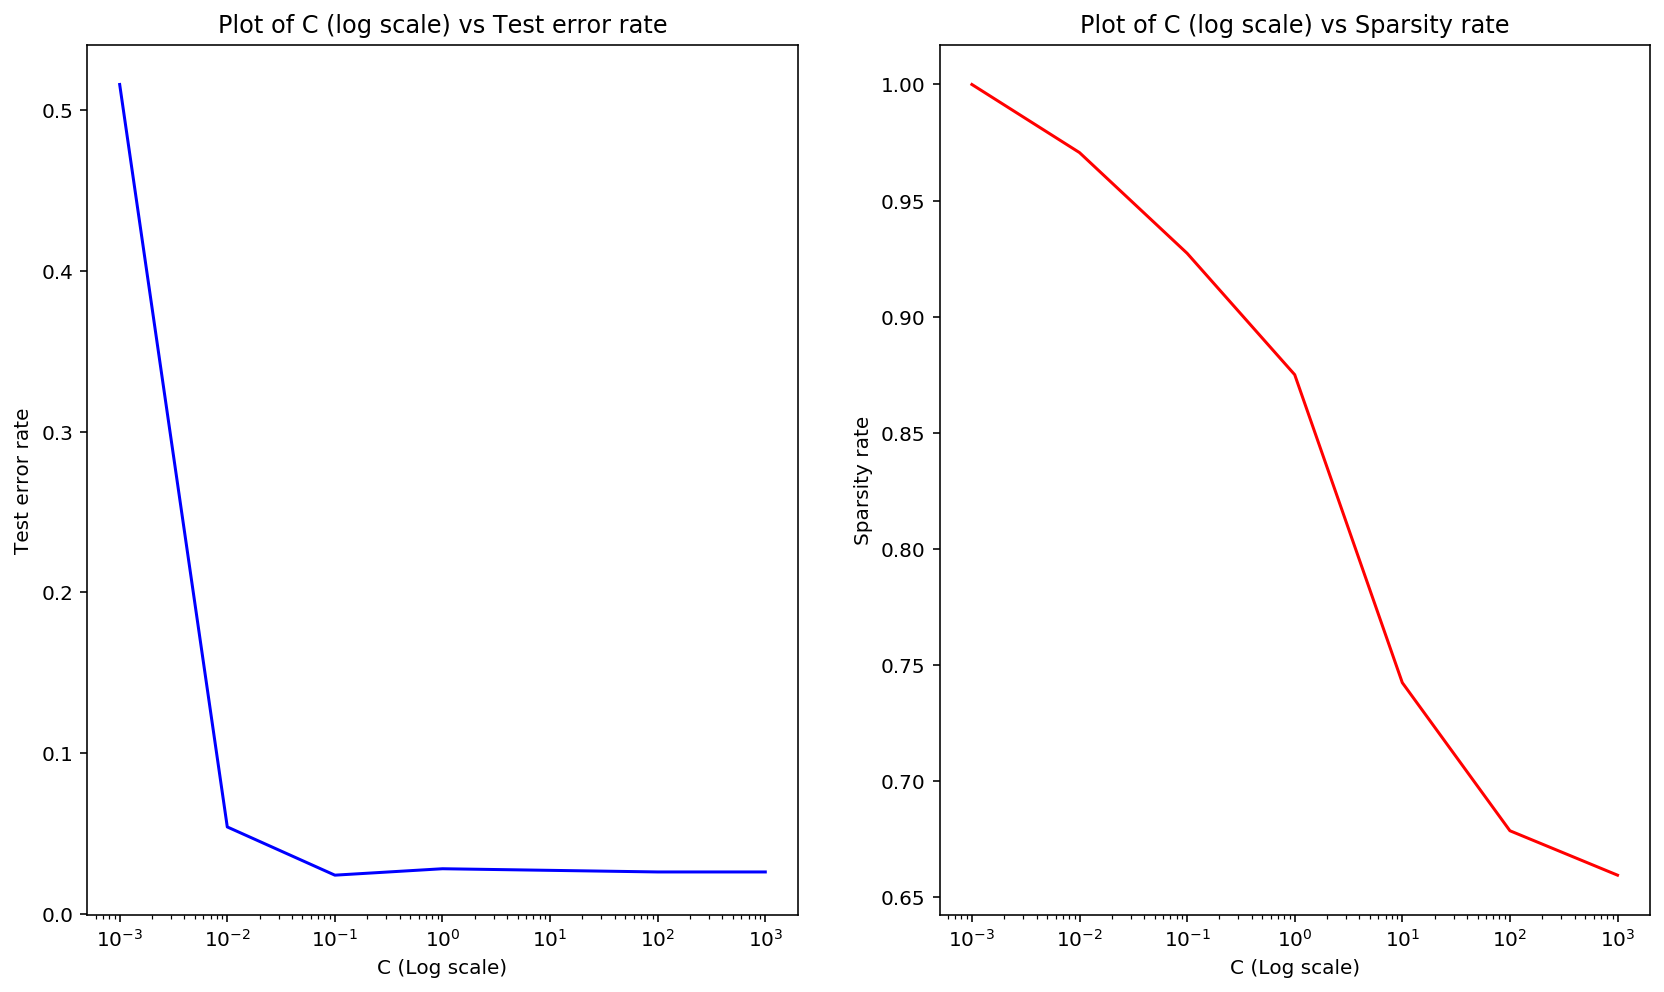

In [15]:
c_list = hist[:,0]
err_list = hist[:,2]
sparsity_list = hist[:,1]

print(err_list)

plt.subplot(1, 2, 1)
plt.title('Plot of C (log scale) vs Test error rate')
plt.xlabel('C (Log scale)')
plt.xscale('log')
plt.ylabel('Test error rate')
plt.plot(c_list, err_list, 'b-')

plt.subplot(1, 2, 2)
plt.title('Plot of C (log scale) vs Sparsity rate')
plt.xlabel('C (Log scale)')
plt.xscale('log')
plt.ylabel('Sparsity rate (Fraction of weights set to 0)')
plt.plot(c_list, sparsity_list, 'r-')

plt.show()

In [20]:
'''
Cross validation
'''

C_values = np.logspace(-3, 3, num=7)
k = 5
results = []
batches_X = np.split(train_X, 5)
batches_y = np.split(train_y, 5)

for C in C_values:
    sparsities = []
    err_rates = []
    print('Training C', C)
    
    for i in range(k):
        batch_train_X, batch_test_X, batch_train_y , batch_test_y = train_test_split(train_X, train_y, test_size=0.4, random_state=0)
        
        model = SVM(C=C, iterations=1000)
        model.fit(batch_train_X, batch_train_y)

        # Sparsify model
        w, b = model.get_params()
        sparsity = (w < 1e-4).sum() / n_features
        sparsities.append(sparsity)
        w[np.abs(w) < 1e-4] = 0

        model.set_params(w, b)

        y_pred = model.predict(test_X)
        err_rate = (y_pred != test_y).mean()
        err_rates.append(err_rate)

    sparsity = np.mean(sparsities)
    err_rate = np.mean(err_rates)

    results.append((C, sparsity, np.std(sparsities), err_rate, np.std(err_rates)))

Training C 0.001
Training C 0.01
Training C 0.1
Training C 1.0
Training C 10.0
Training C 100.0
Training C 1000.0


[0.00000000e+00 0.00000000e+00 1.11022302e-16 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00]


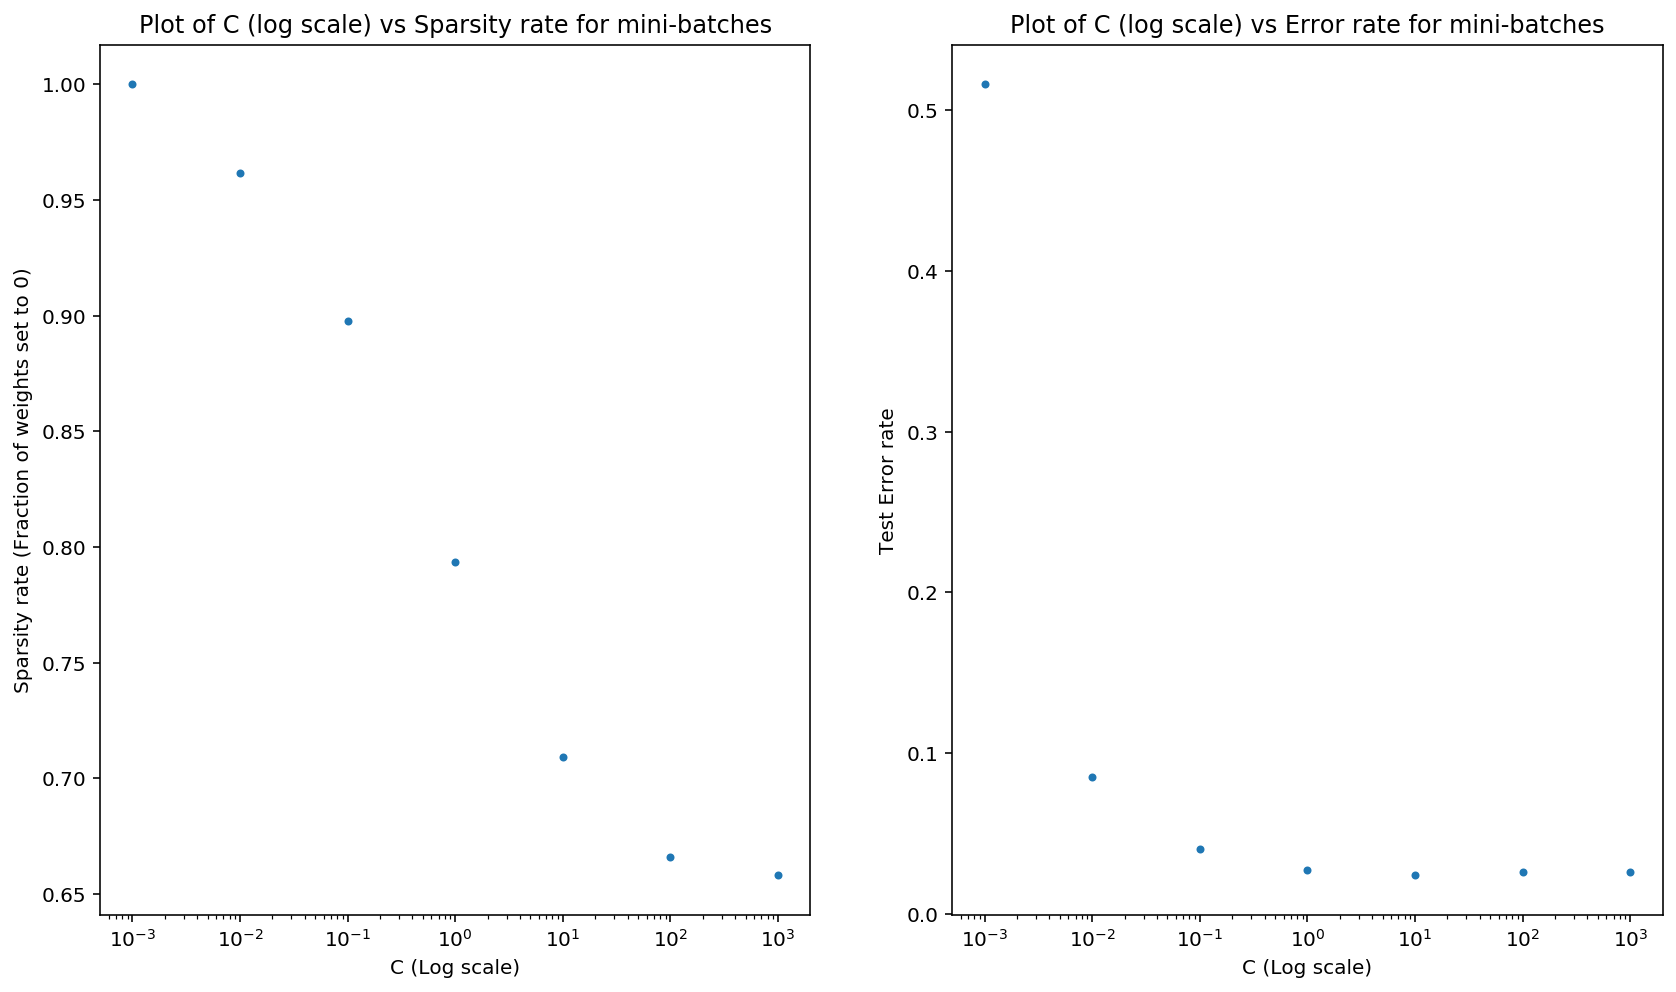

In [21]:
results = np.array(results)

c_list = results[:,0]
sparsity_list = results[:,1]

sparsity_dy = results[:,2]
print(sparsity_dy)
err_list = results[:,3]
err_dy = results[:,4]

plt.subplot(1, 2, 1)
plt.title('Plot of C (log scale) vs Sparsity rate for mini-batches')
plt.xlabel('C (Log scale)')
plt.xscale('log')
plt.ylabel('Sparsity rate (Fraction of weights set to 0)')
plt.errorbar(c_list, sparsity_list, yerr=sparsity_dy, fmt='.');

plt.subplot(1, 2, 2)
plt.title('Plot of C (log scale) vs Error rate for mini-batches')
plt.xlabel('C (Log scale)')
plt.xscale('log')
plt.ylabel('Test Error rate')
plt.errorbar(c_list, err_list, yerr=err_dy, fmt='.');

plt.show()

(600, 784) (400, 784)
